In [4]:
import proplot as pplt
import os
import pandas as pd

# proplot is a wrapper for the matplotlib and cartopy libraries that makes
# plotting maps a lot more pleasant. unfortunately it hasn't been updated 
# in a while, hence the environment file setting python to version 3.9


# loading the buoy data into a dictionary makes it easy to iterate through buoys
buoy_data = {}
save_loc = '../data/iabp/clean/'
for year in range(2003, 2022):
    files = os.listdir(save_loc + str(year))
    print(year, len(files))
    if len(files) > 0:
        buoy_data[year] = {}
        for f in files:
            if '.' != f[0]:
                buoy_data[year][f.replace('.csv', '')] = pd.read_csv(save_loc + str(year) + '/' + f, parse_dates=True)

# This also prints the number of buoys available per year. 
# I've been running Alan's version of my buoy processing code,
# which appears to be overly stringent for data from the first few years
# of the IABP dataset. That's why there's 0 buoys for those years
# I haven't re-run the data processing after 2016 so that's why those folders are empty.

2003 0
2004 0
2005 0
2006 0
2007 0
2008 0
2009 1
2010 3
2011 16
2012 23
2013 27
2014 54
2015 102
2016 98
2017 0
2018 0
2019 0
2020 0
2021 0


/Users/dmw/miniconda3/envs/airsea/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


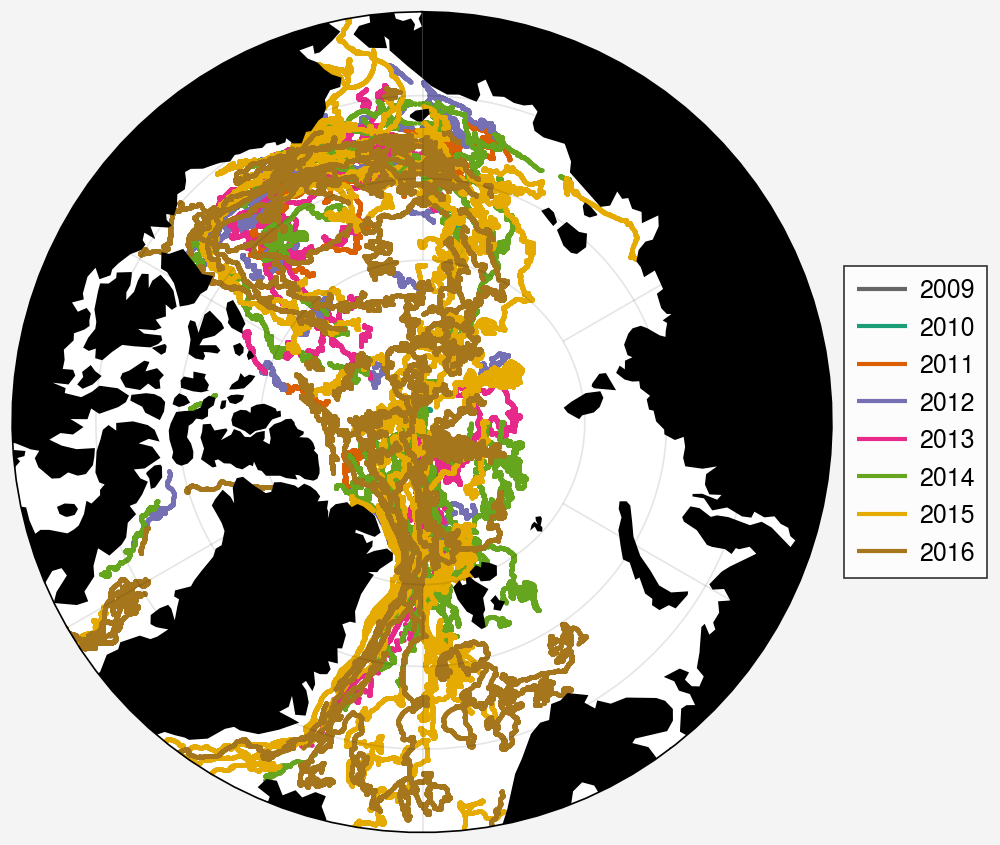

In [7]:
# Making a "spaghetti plot" with all the trajectories on it

# proplot has a nice utility to loop through color maps and cycles
# you can see more in the proplot documentation 
colors = {y: c['color'] for y, c in zip(
            range(2002, 2023),
            pplt.Cycle('dark2', 21))}

# we create a figure and axis object -- here the figure only has one panel, 
# but for more complex figures, it's helpful to be able to loop through as set 
# of axes. 'npstere' is a geographic projection (mapping from true 3d coordinates
# to a flat 2d map) called the "North Polar Stereographic Projection".

fig, ax = pplt.subplots(proj='npstere', width=5)
ax.format(boundinglat=65, land=True)
for year in buoy_data:
    for buoy in buoy_data[year]:
        ax.scatter(buoy_data[year][buoy].longitude,
                buoy_data[year][buoy].latitude, ms=1, color=colors[year])

# a little trick to make a legend: plot nothing, with the color options you want
h = [ax.plot([],[], color=colors[year]) for year in buoy_data]
l = [year for year in buoy_data]
ax.legend(h, l, loc='r', ncols=1)

# Using the NSIDC Sea Ice Concentration Data
The data is stored in netCDF format [docs](https://www.unidata.ucar.edu/software/netcdf/) which is a self-describing multidimensional data format developed especially for geospatial data. It contains dimensions `time` and `x` and `y`. The x, y coordinates are transformed geolocations in the north polar stereographic projection.

In [4]:
import xarray as xr
import proplot as pplt
import cartopy.crs as ccrs

You can load the file with `xr.open_dataset` and see the contents, including variable names and coordinates, and look at the attributes.

In [2]:
ds = xr.open_dataset('../data/nsidc_agg/nsidc_cdr_sic_2002.nc')
ds

/opt/miniconda3/envs/eval_seg/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<xarray.Dataset>
Dimensions:                          (time: 12, y: 448, x: 304)
Coordinates:
  * time                             (time) datetime64[ns] 2002-01-01 ... 200...
  * x                                (x) float64 -3.838e+06 ... 3.738e+06
  * y                                (y) float64 5.838e+06 ... -5.338e+06
Data variables:
    cdr_seaice_conc_monthly          (time, y, x) float32 ...
    cdr_seaice_conc_monthly_stdev    (time, y, x) float32 ...
    cdr_seaice_conc_monthly_qa_flag  (time, y, x) uint8 ...
    crs                              (time) int32 ...
Attributes: (12/46)
    Conventions:               CF-1.11, ACDD-1.3
    date_created:              2024-11-20T21:14:52Z
    time_coverage_start:       2002-01-01T00:00:00Z
    time_coverage_end:         2002-01-31T23:59:59Z
    time_coverage_resolution:  P1M
    time_coverage_duration:    P1M
    ...                        ...
    geospatial_lat_min:        30.980564
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

Here I use ProPlot to plot the image, you can also look into using Cartopy directly. In this case for Cartopy I'd need an extra step if I wanted it to be a circular plot, but that doesn't matter a whole lot. For this simple example both proplot as Cartopy/Matplotlib are equally easy.

/opt/miniconda3/envs/eval_seg/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


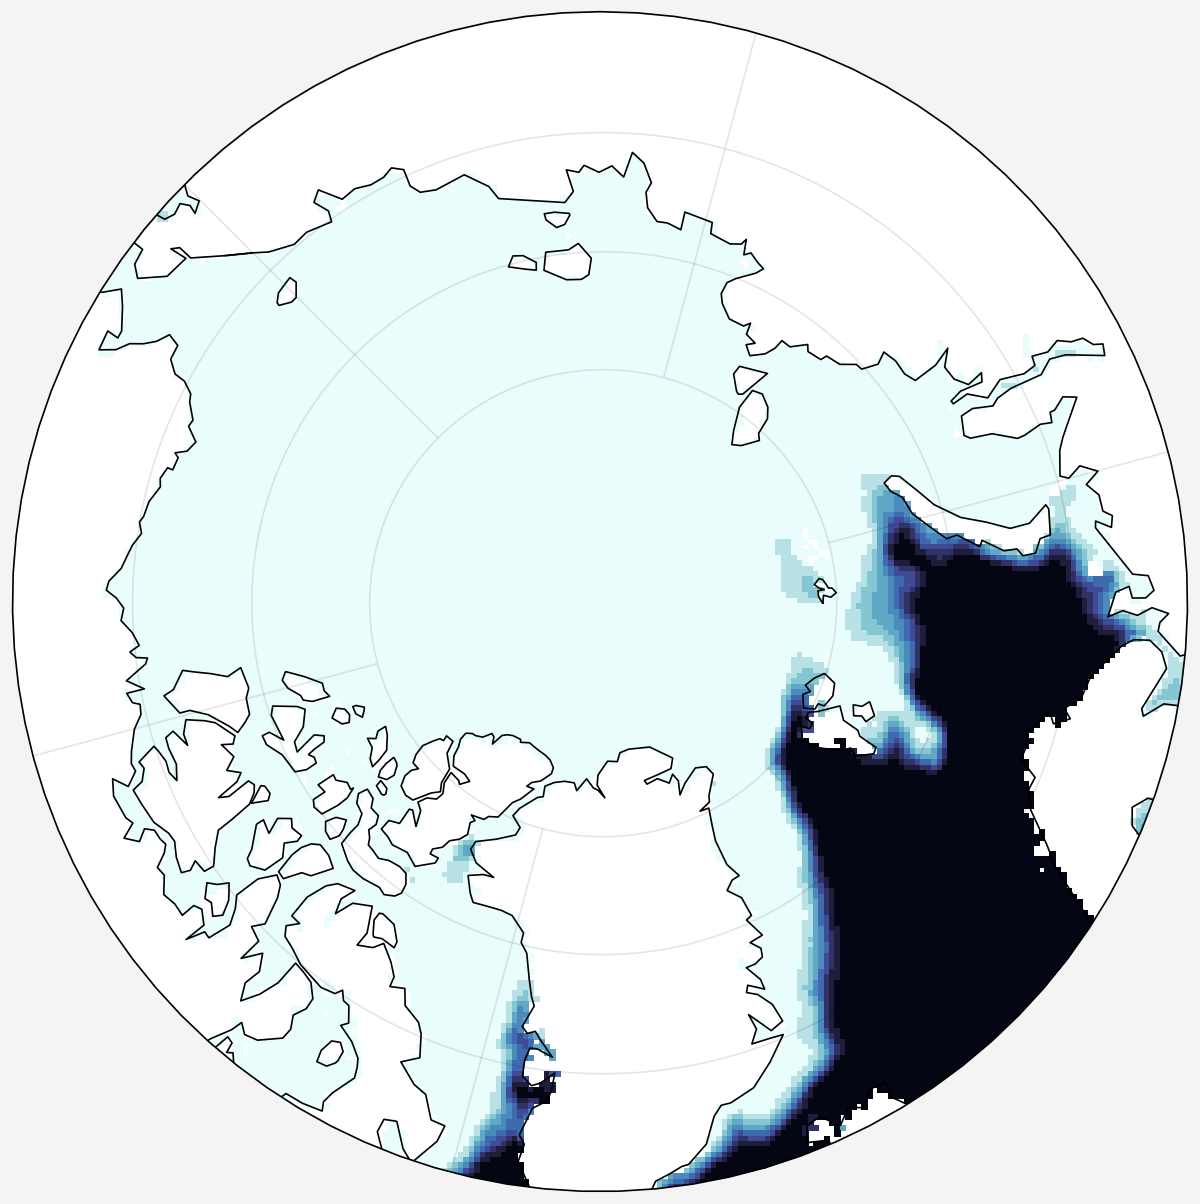

In [18]:
import numpy as np
import pyproj

fig, ax = pplt.subplots(proj='npstere', proj_kw={'lon_0': -45, 'true_scale_latitude': 70}, width=6)
ax.format(coast=True, boundinglat=65)
# Setup the polar stereographic coordinate arrays

ax.pcolormesh(ds.x.data, ds.y.data, ds.isel(time=0)['cdr_seaice_conc_monthly'].data, vmin=0, vmax=1, cmap='ice',
           transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))

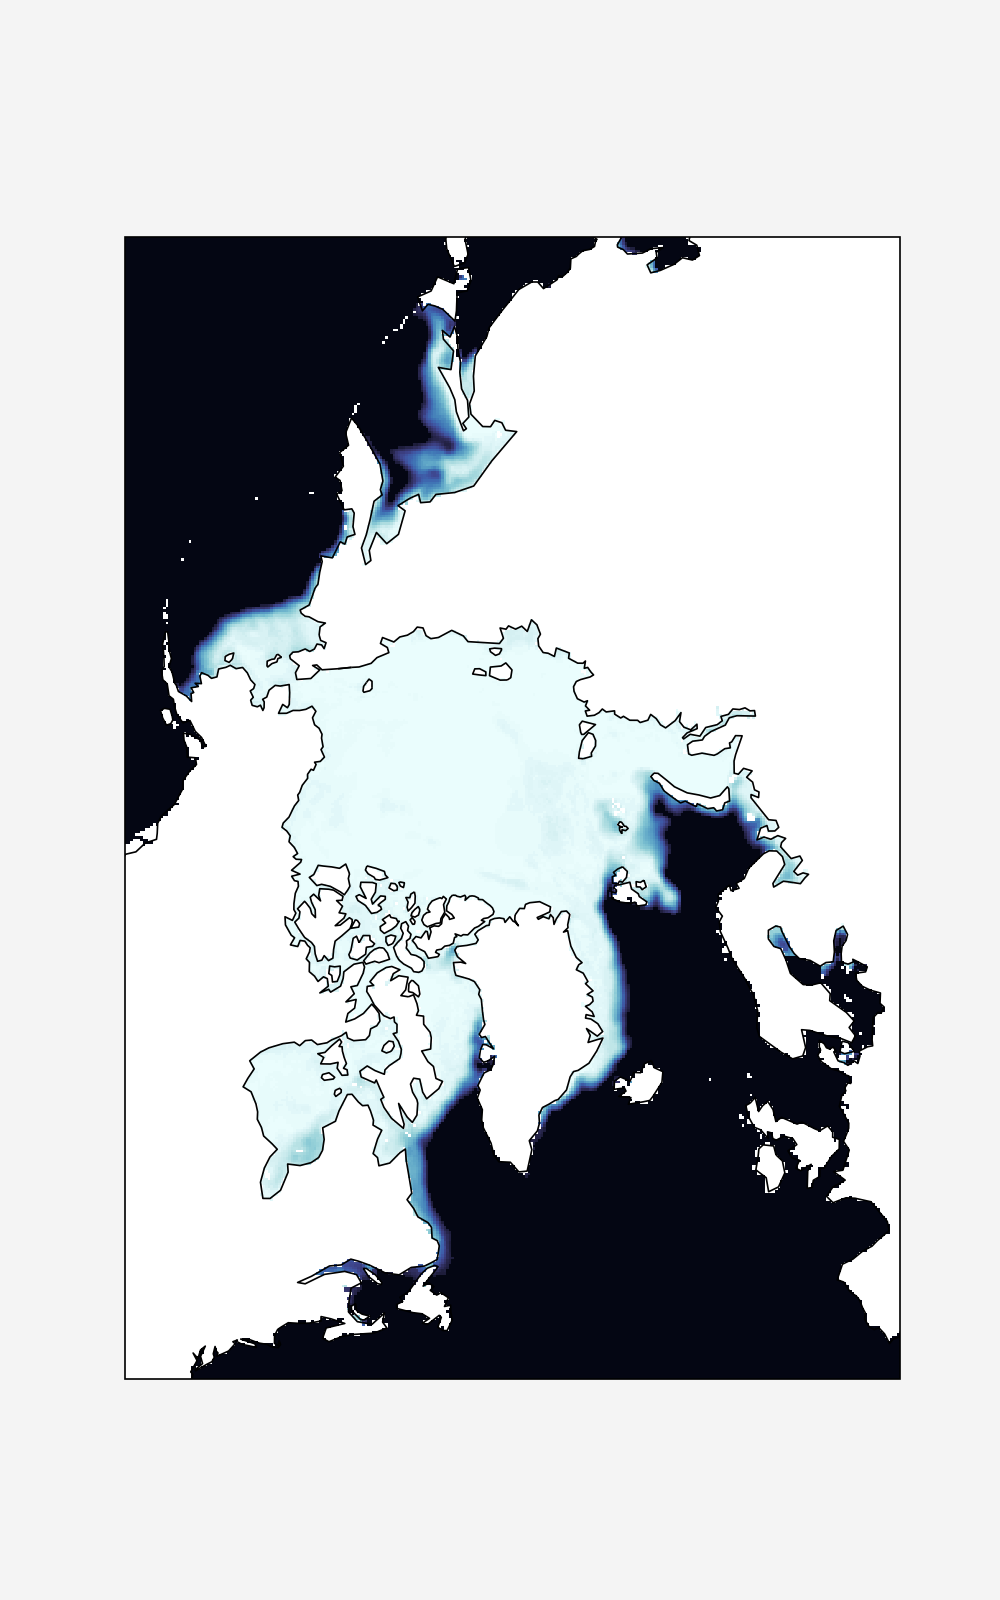

In [31]:
# Similar figure with cartopy directly
import os
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 8))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))

ax.pcolormesh(ds.x.data, ds.y.data, ds.isel(time=0)['cdr_seaice_conc_monthly'].data, vmin=0, vmax=1, cmap='ice',
             transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70), shading='auto')

ax.coastlines()